In [ ]:
!pip install datasets
!pip install transformers
!pip install evaluate


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from datasets import load_dataset

# dataset = load_dataset("story_cloze", data_dir='https://goo.gl/XWjas1')

In [ ]:
import re
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelWithLMHead
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class StoriesDataset(Dataset):  
    def __init__(self, tokenizer, init_token, story, max_len):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.eos = self.tokenizer.eos_token
        self.eos_id = self.tokenizer.eos_token_id
        self.story = story
        self.allTokenizedStories = []
        self.allTokenizedStories2 = []
        tokenizer.pad_token = tokenizer.eos_token
        i=0
        for story in self.story:
            # Encode the text using tokenizer.encode(). We ass EOS at the end
            tokenized_output=self.tokenizer(init_token[i] + story + self.eos,truncation=True,padding='max_length',max_length=13)
            ''' Here we are convertint to pytorch tensor'''
            self.allTokenizedStories.append(torch.tensor(tokenized_output['input_ids']))
            
            i+=1
            
    def __len__(self):
        return len(self.allTokenizedStories)


    def __getitem__(self, item):
        tmp = self.allTokenizedStories[item]
        if(tmp[-1]!=50256):
            xx=0
        return self.allTokenizedStories[item]

In [ ]:
#loading dataset from a csv file of movie names
movies_file = "/content/ROCStories_winter2017 - ROCStories_winter2017.csv"
max_length = 100
df = pd.read_csv(movies_file)
story = df['sentence1'] + df['sentence2'] + df['sentence3'] + df['sentence4'] + df['sentence5']
init_token = df['storytitle'] 
story = list(story) #converting from pandas to list
for i in range(len(story)):  #removing year from title
    story[i]=re.sub("\([0-9]+\)", "", story[i]).strip()

In [ ]:
#LOADING GPT model and tokenizers
tokenizer = AutoTokenizer.from_pretrained("gpt2",cache_dir="/content/drive/MyDrive/HuggingFace/")
# extra_length = len(tokenizer.encode("story: ")) 
model = AutoModelWithLMHead.from_pretrained("gpt2",cache_dir="/content/drive/MyDrive/HuggingFace/")
model = model.to(device)


/usr/local/lib/python3.8/dist-packages/transformers/models/auto/modeling_auto.py:1248: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [ ]:
#datasets and dataloaders
dataset = StoriesDataset(tokenizer, init_token, story, max_length)
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

52665


In [ ]:
epochs=5
epoch_loss = []
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
for epoch in range(epochs):
    for idx, batch in enumerate(dataloader):        
        batch = batch.to(device)
        output = model(batch, labels=batch)
        loss = output.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()        
        if idx % 50 == 0:
            print("loss: %f, %d"%(loss, idx))
    epoch_loss.append(loss)

loss: 5.771758, 0
loss: 3.535780, 50
loss: 3.481478, 100
loss: 3.356304, 150
loss: 3.423849, 200
loss: 3.407702, 250
loss: 3.451721, 300
loss: 3.305101, 350
loss: 3.434169, 400
loss: 2.899583, 0
loss: 2.905096, 50
loss: 3.008685, 100
loss: 2.833274, 150
loss: 3.024687, 200
loss: 3.074732, 250
loss: 3.045195, 300
loss: 3.068429, 350
loss: 3.153357, 400
loss: 2.552759, 0
loss: 2.536513, 50
loss: 2.542290, 100
loss: 2.526964, 150
loss: 2.547425, 200
loss: 2.623825, 250
loss: 2.621538, 300
loss: 2.544256, 350
loss: 2.681048, 400
loss: 2.047628, 0
loss: 2.059752, 50
loss: 2.150474, 100
loss: 2.066739, 150
loss: 2.203556, 200
loss: 2.190185, 250
loss: 2.255017, 300
loss: 2.320131, 350
loss: 2.181435, 400
loss: 1.707626, 0
loss: 1.707549, 50
loss: 1.739377, 100
loss: 1.688436, 150
loss: 1.733646, 200
loss: 1.769408, 250
loss: 1.805713, 300
loss: 1.837332, 350
loss: 1.881763, 400


In [ ]:
L= [epoch_loss[i]]


In [ ]:
L=[i.item() for i in epoch_loss]

<AxesSubplot:>

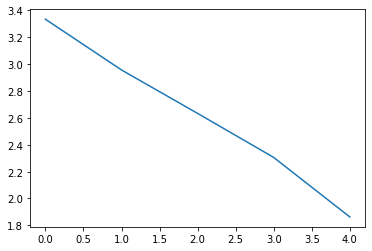

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data=L)

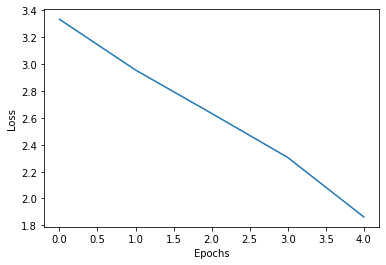

In [ ]:
ax = sns.lineplot(data=L)
ax.set(xlabel='Epochs', ylabel='Loss')
plt.show()

In [ ]:
torch.save(model,"/content/drive/MyDrive/HuggingFace/model.pt")

In [ ]:
#inference

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model=torch.load("/content/model.pt")
model=model.to(device)
tokenizer = AutoTokenizer.from_pretrained("gpt2",cache_dir="/content/drive/MyDrive/HuggingFace/")


input_ids = tokenizer.encode('Not Done',return_tensors='pt')
input_ids=input_ids.to(device)
sample_outputs = model.generate(
    input_ids,
    do_sample=True, 
    max_length=100, 
    top_k=9,    
    num_return_sequences=10
    
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

cuda


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
0: Not Done yet?John was helping Tim out with his auto insurance.Both of them realized that their car had been broken down.They could not afford the payments on the payments.They had not been paid on their car.They had been.They had been on the same month, and they could barely paid on each other.They had any money for months.They had any time to spend.After a week.They had no money to pay on each other.They drove each other out of
1: Not Done with datingBrianna never had a serious date.She had been with someone.She thought she met on a date only online.She thought she thought she had met on a forum with random girls were in a lotes.When she thought she didn't accepted any of romance.At first dated at first.When someone else's name's name was called out.Someone tried to ask her out.She tried to charm someone else for her first.She tried to impress someone flatly
2: Not Done yet?

In [ ]:
tokenizer("What is Blockchain w.r.t ledger, A Blockchain is a constantly growing ledger(file) that keeps a permanent record of all the transactions that have taken place, in a secure, chronological, and immutable way. It can be used for the secure transfer of money, property, contracts, etc. without requiring a third-party intermediary like bank or government.Blockchain is the backbone of the most famous cryptocurrency named Bitcoin. It is a peer to peer electronic cash system and a decentralized network which allows users to make transactions directly without the involvement of third-party to manage the exchange of funds.")

{'input_ids': [2061, 318, 29724, 266, 13, 81, 13, 83, 37208, 11, 317, 29724, 318, 257, 7558, 3957, 1849, 992, 1362, 7, 7753, 8, 326, 7622, 257, 7748, 1700, 286, 477, 262, 8945, 326, 423, 2077, 1295, 11, 287, 257, 5713, 11, 45946, 11, 290, 40139, 835, 13, 632, 460, 307, 973, 329, 262, 5713, 4351, 286, 1637, 11, 3119, 11, 8592, 11, 3503, 13, 1231, 10616, 257, 2368, 12, 10608, 45193, 588, 3331, 393, 1230, 13, 12235, 7983, 318, 262, 32774, 286, 262, 749, 5863, 20210, 3706, 6185, 13, 632, 318, 257, 12720, 284, 12720, 7914, 5003, 1080, 290, 257, 26512, 3127, 543, 3578, 2985, 284, 787, 8945, 3264, 1231, 262, 9750, 286, 2368, 12, 10608, 284, 6687, 262, 5163, 286, 5153, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
# model_inputs = tokenizer("You are one of the famous person of holy Land of Muslims")

In [ ]:
print(model_inputs['input_ids'])

[1639, 389, 530, 286, 262, 5863, 1048, 286, 11386, 6379, 286, 7045]


In [ ]:
tokenizer.decode(model_inputs["input_ids"])

'You are one of the famous person of holy Land of Muslims'